## Using Bound Rectangle of minimum area from opencv library to find out the borders of the csDNA origami to calculate the position of the robot

10484.0
8620.5
3163.5
3040.0
91 224
210 382


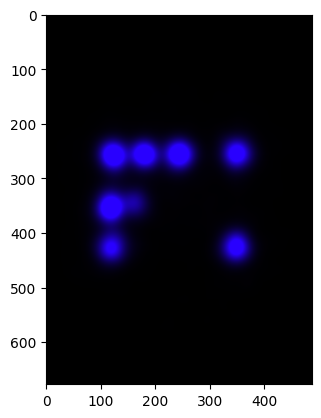

In [28]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def ImageOrientation(img_path):
    # Load the image from the given path
    img = cv.imread(img_path)
    copy_1 = img.copy()

    # Convert the image to grayscale
    gray_1 = cv.cvtColor(copy_1, cv.COLOR_BGR2GRAY)

    # Apply a threshold to the image
    ret, thresh_1 = cv.threshold(gray_1, 20, 255, cv.THRESH_TOZERO)

    # Find the contours of the image
    contours_1, hierarchy = cv.findContours(thresh_1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the image
    cv.drawContours(copy_1, contours_1, -1, (0, 255, 0), 5)

    # Sorting the contours by area
    contours_1 = sorted(contours_1, key=cv.contourArea, reverse=True)

    # Printing the area of each contour
    for contour in contours_1:
        print(cv.contourArea(contour))

    # Concatenate the contours into a single contour
    single_contour = np.concatenate(contours_1)

    # Using the single_contour to draw the contour on the image
    cv.drawContours(copy_1, [single_contour], -1, (0, 255, 0), 5)

    # Using bounding rectangle to rotate the image to align properly
    rect = cv.minAreaRect(single_contour)

    box = cv.boxPoints(rect)
    box = np.int64(box)

    cv.drawContours(copy_1, [box], 0, (0, 0, 255), 2)

    # Get the rotation angle and adjust it to ensure the longer side is parallel to the x-axis
    angle = rect[2]
    if rect[1][0] < rect[1][1]:
        angle += 90
    rows, cols = img.shape[:2]
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    dst = cv.warpAffine(img, M, (cols, rows))

    # Making a copy of the rotated image
    copy_2 = dst.copy()
    copy_3 = dst.copy()
    
    # Drawing the contours on the rotated image copy_2
    gray_2 = cv.cvtColor(copy_2, cv.COLOR_BGR2GRAY)
    ret, thresh_2 = cv.threshold(gray_2, 20, 255, cv.THRESH_TOZERO)
    contours_2, hierarchy = cv.findContours(thresh_2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(copy_2, contours_2, -1, (0, 255, 0), 5)

    # Sorting the contours by area
    contours_2 = sorted(contours_2, key=cv.contourArea, reverse=True)


    # Finding the position of the first contour
    x_1, y_1, w_1, h_1 = cv.boundingRect(contours_2[0])
    print(x_1, y_1)

    # Rotating copy_3 by 180 degrees
    rows, cols = copy_3.shape[:2]
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), 180, 1)
    dst_2 = cv.warpAffine(copy_3, M, (cols, rows))

    # Making a copy of the rotated image
    copy_4 = dst_2.copy()

    # Drawing the contours on the rotated image copy_4
    gray_3 = cv.cvtColor(copy_4, cv.COLOR_BGR2GRAY)
    ret, thresh_3 = cv.threshold(gray_3, 20, 255, cv.THRESH_TOZERO)
    contours_3, hierarchy = cv.findContours(thresh_3, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(copy_4, contours_3, -1, (0, 255, 0), 5)

    # Sorting the contours by area
    contours_3 = sorted(contours_3, key=cv.contourArea, reverse=True)

    # Printing the coordinates of the first contour
    x_2, y_2, w_2, h_2 = cv.boundingRect(contours_3[0])
    print(x_2, y_2)

    # Determine the final image orientation
    if x_1 < x_2 and y_1 < y_2:
        final_img = dst
    else:
        final_img = dst_2

    # Making a copy of the final image
    final_img_copy = final_img.copy()

    return final_img, final_img_copy


final_img, final_img_copy = ImageOrientation('/workspaces/CSDNA/Testing code/Robot Movement/Data/v8_t=0_avg.png')

plt.imshow(final_img)
plt.show()

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def calculate_center_of_mass(contour, data):
    com_x = 0
    com_y = 0
    total_intensity = 0

    for i in range(len(data)):
        for j in range(len(data[i])):
            if cv.pointPolygonTest(contour, (j, i), False) == 1:
                com_x += j * data[i][j]
                com_y += i * data[i][j]
                total_intensity += data[i][j]

    com_x /= total_intensity
    com_y /= total_intensity

    return com_x, com_y

def find_rightmost_contours(contours):
    right_most_contour = max(contours, key=lambda contour: cv.boundingRect(contour)[0])
    second_right_most_contour = max(
        (contour for contour in contours if contour is not right_most_contour),
        key=lambda contour: cv.boundingRect(contour)[0]
    )
    return right_most_contour, second_right_most_contour

#finding the left most contour using center of mass of the contour
def find_leftmost_contours(contours,data):
    left_most_contour = min(contours, key=lambda contour: calculate_center_of_mass(contour, data)[0])
    return left_most_contour

def draw_and_sort_contours(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray, 20, 255, cv.THRESH_TOZERO)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(img, contours, -1, (0, 255, 0), 2)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    return img, contours

def plot_3d_scatter(data, contours=None, contour=None, title='Interactive 3D Plot of Pixel Intensities', markers=[]):
    x = []
    y = []
    z = []

    if contours:
        for i in range(len(data)):
            for j in range(len(data[i])):
                for cnt in contours:
                    if cv.pointPolygonTest(cnt, (j, i), False) == 1:
                        x.append(j)
                        y.append(-i)
                        z.append(data[i][j])
    elif contour is not None:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if cv.pointPolygonTest(contour, (j, i), False) == 1:
                    x.append(j)
                    y.append(-i)
                    z.append(data[i][j])

    # Convert lists to numpy arrays for calculation
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    # Create the 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=z,
            colorscale='Viridis',
            colorbar=dict(title='Pixel Intensity'),
            opacity=0.8
        )
    )])

    # Add additional markers
    for marker in markers:
        fig.add_trace(go.Scatter3d(
            x=[marker['x']],
            y=[marker['y']],
            z=[np.max(z)+5],
            mode='markers',
            marker=dict(
                size=4,
                color=marker['color']
            ),
            name=marker['name']
        ))

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis_title='X Label',
            yaxis_title='Y Label',
            zaxis_title='Z Label',
        ),
        title=title
    )

    # Rotate the plot by 180 degrees (adjust angles as needed)
    fig.update_layout(scene_camera=dict(
        eye=dict(x=2, y=2, z=1)  # Change this as needed to adjust the view
    ))

    fig.show()
    
def distance_point_to_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    m = (y2-y1) / (x2-x1)
    c = y1 - m*x1
    x = (m*y0 + x0 - m*c) / (m**2 + 1)
    y = m*x + c
    return x, y


In [8]:
def calculate_exact_ratio(data, contours, final_img_copy):
    # Finding the rightmost and second rightmost contours
    right_most_contour, second_right_most_contour = find_rightmost_contours(contours)

    # Calculate the center of mass for the rightmost and second rightmost contours
    com_right_most_x, com_right_most_y = calculate_center_of_mass(right_most_contour, data)
    com_second_right_most_x, com_second_right_most_y = calculate_center_of_mass(second_right_most_contour, data)

    # Find the leftmost contour
    left_most_contour = find_leftmost_contours(contours, data)

    # Calculate the center of mass for the leftmost contour
    com_left_most_x, com_left_most_y = calculate_center_of_mass(left_most_contour, data)

    # Picking the contour with the lowest intensity
    min_intensity = 255
    min_intensity_contour = None
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        intensity = np.mean(data[y:y+h, x:x+w])
        if intensity < min_intensity:
            min_intensity = intensity
            min_intensity_contour = contour

    # Calculate the center of mass for the minimum intensity contour
    center_of_mass_x, center_of_mass_y = calculate_center_of_mass(min_intensity_contour, data)

    # Define the right line using the centers of the rightmost and second rightmost contours
    right_line = [(com_right_most_x, com_right_most_y), (com_second_right_most_x, com_second_right_most_y)]

    # Define the left point using the center of mass of the leftmost contour
    left_point = (com_left_most_x, com_left_most_y)

    # Calculate the distance of the left point from the right line
    distance_left_to_right_line = distance_point_to_line(left_point, right_line)

    # Define the center of mass point using the minimum intensity contour
    center_of_mass_point = (center_of_mass_x, center_of_mass_y)

    # Calculate the distance of the center of mass point from the right line
    distance_center_of_mass_to_right_line = distance_point_to_line(center_of_mass_point, right_line)

    # Calculate the exact ratio
    ratio = distance_center_of_mass_to_right_line / distance_left_to_right_line
    
    # Getting the intersection point
    intersection_point_x, intersection_point_y = intersection_between_point_line(left_point, right_line)
    
    # Getting the intersection point for the center of mass
    intersection_point_x_center_of_mass, intersection_point_y_center_of_mass = intersection_between_point_line(center_of_mass_point, right_line)
    
    #drawing all the centers contours and linnes on the final_avg_image
    final_avg_image = final_img_copy.copy()
    cv.circle(final_avg_image, (int(center_of_mass_x), int(center_of_mass_y)), 3, (0, 255, 0), -1)
    cv.circle(final_avg_image, (int(com_right_most_x), int(com_right_most_y)), 3, (0, 255, 0), -1)
    cv.circle(final_avg_image, (int(com_second_right_most_x), int(com_second_right_most_y)), 3, (0, 255, 0), -1)
    cv.circle(final_avg_image, (int(com_left_most_x), int(com_left_most_y)), 3, (0, 255, 0), -1)
    cv.line(final_avg_image, (int(com_right_most_x), int(com_right_most_y)), (int(com_second_right_most_x), int(com_second_right_most_y)), (0, 255, 0), 2)
    cv.line(final_avg_image, (int(com_left_most_x), int(com_left_most_y)), (int(intersection_point_x), int(intersection_point_y)), (0, 255, 0), 2)
    cv.circle(final_avg_image, (int(center_of_mass_x), int(center_of_mass_y)), 2, (0, 255, 0), -1)
    cv.line(final_avg_image, (int(center_of_mass_x), int(center_of_mass_y)), (int(intersection_point_x_center_of_mass), int(intersection_point_y_center_of_mass)), (0, 255, 0), 2)
    
    #writing the ratio on the final_avg_image
    cv.putText(final_avg_image, f'Ratio: {ratio:.6f}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Showing the final_avg_image
    plt.imshow(final_avg_image)
    plt.show()

    return ratio, distance_left_to_right_line, distance_center_of_mass_to_right_line


In [9]:
import os

def process_images_in_directory(directory_path):
    image_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]
    image_files.sort()  # Ensure files are processed in a specific order

    for image_file in image_files:
        img_path = os.path.join(directory_path, image_file)
        final_img, final_img_copy = ImageOrientation(img_path)
        data = final_img_copy[:, :, 0].astype(np.int64)  # Ensure data is of type int32
        final_img, contours = draw_and_sort_contours(final_img)
        ratio, distance_left, distance_center_of_mass = calculate_exact_ratio(data, contours, final_img_copy)

        print(f'Image: {image_file}')
        print(f'Ratio: {ratio:.10f}')
        print(f'Distance from leftmost point to right line: {distance_left:.10f}')
        print(f'Distance from center of mass of minimum contour to right line: {distance_center_of_mass:.10f}')
        print('')

96296.5
59542.5
50045.5
34750.5
25214.5
224 22
527 412


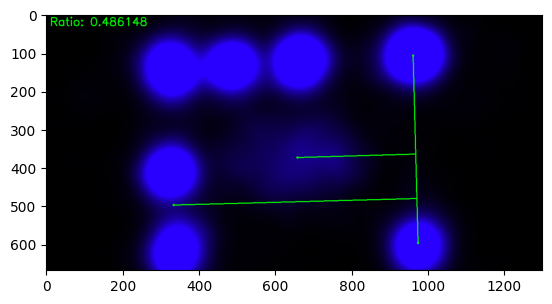

Image: t=0[1]avg.png
Ratio: 0.4861484292
Distance from leftmost point to right line: 637.3510354020
Distance from center of mass of minimum contour to right line: 309.8472047222

96342.0
64099.5
50092.5
34766.0
26651.5
0.0
559 443
271 42


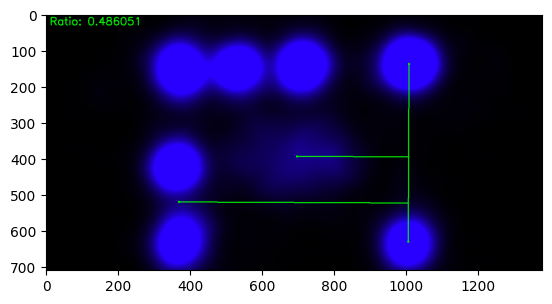

Image: t=0avg.png
Ratio: 0.4860514642
Distance from leftmost point to right line: 637.2624730691
Distance from center of mass of minimum contour to right line: 309.7423581032

3445.0
2291.5
1102.0
1050.0
994.5
152 172
114 101


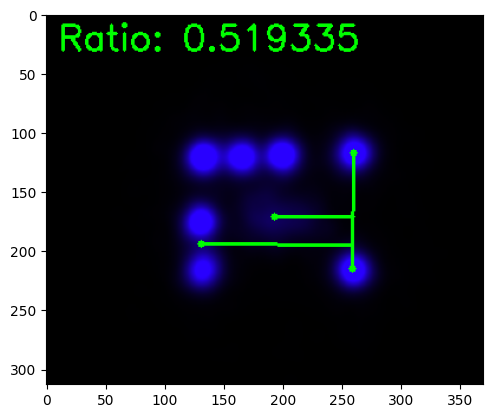

Image: t=24avg.png
Ratio: 0.5193350513
Distance from leftmost point to right line: 128.4805273641
Distance from center of mass of minimum contour to right line: 66.7244412648

3564.5
2352.0
1348.0
1185.0
1070.5
131 178
95 113


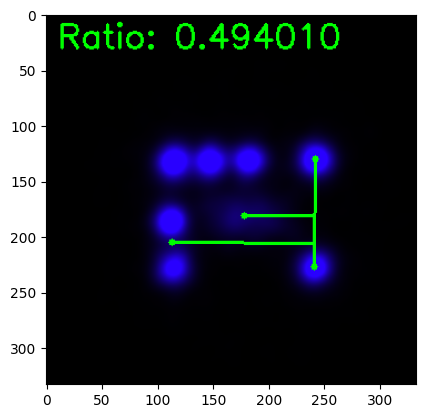

Image: t=48avg.png
Ratio: 0.4940104794
Distance from leftmost point to right line: 128.5489000363
Distance from center of mass of minimum contour to right line: 63.5045037280

10484.0
8620.5
3163.5
3040.0
2709.0
231.0
114.0
66.0
52.0
52.0
52.0
39.5
36.5
6.0
886 314
905 506


/tmp/ipykernel_9399/1197644234.py:18: RuntimeWarning: invalid value encountered in scalar divide
  com_x /= total_intensity
/tmp/ipykernel_9399/1197644234.py:19: RuntimeWarning: invalid value encountered in scalar divide
  com_y /= total_intensity


ValueError: cannot convert float NaN to integer

In [15]:
# Process all images in the directory
process_images_in_directory('/workspaces/CSDNA/Testing code/Robot Movement/Data')

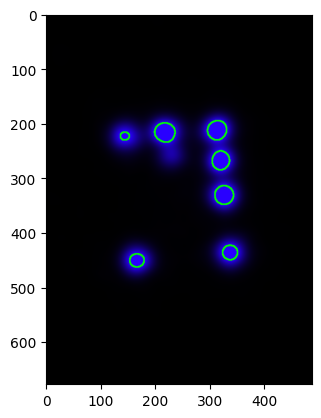

In [27]:
# Process a single image
img_path = '/workspaces/CSDNA/Testing code/Robot Movement/Data/v8_t=0_avg.png'

# Load the image
img = cv.imread(img_path)

# Convert the image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply a threshold to the image
ret, thresh = cv.threshold(gray, 80, 255, cv.THRESH_TOZERO)

# Find the contours of the image
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Draw the contours on the image
cv.drawContours(img, contours, -1, (0, 255, 0), 2)

# Sorting the contours by area
contours = sorted(contours, key=cv.contourArea, reverse=True)

# showing the image for debugging
plt.imshow(img)
plt.show()

1277.5
1206.5
1153.5
1097.5
788.5
722.5
422.0
90 224
211 381


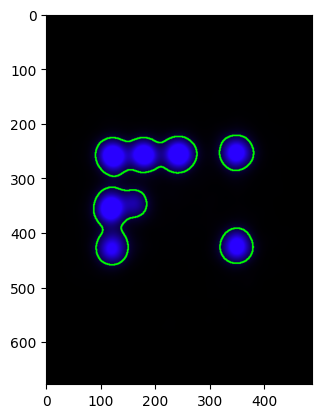

In [22]:
# Load the image
final_img, final_img_copy = ImageOrientation('/workspaces/CSDNA/Testing code/Robot Movement/Data/v8_t=0_avg.png')

data = final_img_copy[:, :, 0]

# Draw the contours on the image
final_img, contours = draw_and_sort_contours(final_img)

plt.imshow(final_img)
plt.show()

#plotting the 3D scatter plot
plot_3d_scatter(data, contours=contours, title='Interactive 3D Plot of Pixel Intensities with Contours')

In [11]:
# Picking the contour with lowest intensity
min_intensity = 255
min_intensity_contour = None
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    intensity = np.mean(data[y:y+h, x:x+w])
    if intensity < min_intensity:
        min_intensity = intensity
        min_intensity_contour = contour

# Drawing the center of the min_intensity_contour using weighted arithmetic mean of the contour using the pixel intensity as the weight
center_of_mass_x, center_of_mass_y = calculate_center_of_mass(min_intensity_contour, data)

# Add the center of mass to the plot
markers = [
    {'x': center_of_mass_x, 'y': -center_of_mass_y, 'z': 0, 'color': 'red', 'name': 'COM Min Intensity Contour'}
]

# Plot the 3D scatter plot with the center of mass
plot_3d_scatter(data, contour=min_intensity_contour, title='Interactive 3D Plot of Pixel Intensities with Min Intensity Contour and Center of Mass', markers=markers)

In [14]:
# Finding the rightmost and second rightmost contours
right_most_contour, second_right_most_contour = find_rightmost_contours(contours)

# Calculate the center of mass for the rightmost and second rightmost contours
com_right_most_x, com_right_most_y = calculate_center_of_mass(right_most_contour, data)
com_second_right_most_x, com_second_right_most_y = calculate_center_of_mass(second_right_most_contour, data)

# Add the center of mass to the plot
markers = [
    {'x': com_right_most_x, 'y': -com_right_most_y, 'z': 0, 'color': 'red', 'name': 'COM Rightmost'},
    {'x': com_second_right_most_x, 'y': -com_second_right_most_y, 'z': 0, 'color': 'red', 'name': 'COM Second Rightmost'}
]

# Plot the 3D scatter plot with the center of mass
plot_3d_scatter(data, contours=contours, title='Interactive 3D Plot of Pixel Intensities with Contours and Center of Mass', markers=markers)

* Threshold and finding the center of masses of the upper for a copy image
* another copy image to find the contour of the robot using upper threshold and to zero inv from open cv thresholding 
* using copy image to make a coordinate system using the centerofmass of the top left as the origin and then the right as the final